# 第4章 非平稳序列的随机分析

## 1 导入库

In [15]:
import datetime
import pandas as pd
import numpy as np
import os
import matplotlib as  mpl
from dateutil.relativedelta  import relativedelta
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


习题数据="./习题与案例数据/习题数据/"
案例数据="./习题与案例数据/案例数据/"
from statsmodels.tsa.stattools import acf,pacf,adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA,ARMA

from statsmodels.regression.linear_model import OLS

In [16]:
# 使用Q_LB进行白噪音假设
def my_Q_LB(ts,out_lags_list=[10],p_threshold=0.05):
    from scipy.stats  import  chi2
    n=len(ts)
    acf_ts=acf(ts,nlags=n)

    list_df=[]
    for l in out_lags_list:
        q_lb=sum([n*(n+2)*acf_ts[k]**2/(n-k)  for k in range(1,l+1) ])
        p=1- chi2.cdf(q_lb,l)
        tmp_l=[l,q_lb,p,p>p_threshold]
        list_df.append(tmp_l)

    df=pd.DataFrame(list_df,columns=['延迟期数','Q_LB统计量','P值','接受白噪音假设'])
    return df
  
# 绘制acf图    
def my_plt_acf(ts,out_lags=10):
    acf_ts=acf(ts)[:out_lags+1]
    df=pd.Series(acf_ts)
    df.index+=1
    df.plot(title='acf',marker='o',grid=True)
    plt.axhline(y=0,color='red')
    plt.show()
    print(df)
    
# 生成adf校验表，判断序列是否平稳，类似参数书上P227；用来确定阶数
def adf_check_table(ts,max_lag=3,threshod=0.05):
    DICT_REGRESSION={'nc':'类型1',
                 'c':'类型2',
                 'ct':'类型3'}
    list_df=[]
    for i_reg in DICT_REGRESSION.keys():
        for i in range(max_lag+1):
            dftest=adfuller(ts,maxlag=i,regression=i_reg,autolag=None)
            dfoutput=pd.Series([DICT_REGRESSION[i_reg],i,'平稳' if dftest[1]<threshod else '非平稳']+list(dftest[0:4]),
                               index=['类型','延迟阶数','检验结果','Test Statistic','p-value','Lags Used',
            'Number of observations Used'])
            for key,value in dftest[4].items():
                dfoutput['Critical value(%s)'%key]=value
            list_df.append(dfoutput)
    return pd.concat(list_df,axis=1).transpose()    

# 仅限于ARIMA
def confidence_interval(results,steps=5,alpha=0.05):
    val,st,intv=results.forecast(steps=steps,alpha=alpha)
    return pd.DataFrame(np.concatenate([val.reshape(-1,1),st.reshape(-1,1),intv],axis=1),columns=['预测值','标准差','{:,.0%}置信区间下限'.format(alpha),'{:,.0%}置信区间上限'.format(alpha)])
    
# 检查序列的异方差性
def my_LM_test(ts,out_lags_list=range(1,11),p_threshold=0.05):
    from statsmodels.stats.diagnostic import het_arch
    list_df=[]
    for l in out_lags_list:
        rst=het_arch(ts,maxlag=l)
        tmp_l=[l]+list(rst[:2])+[rst[1]<p_threshold]
        list_df.append(tmp_l)
    df=pd.DataFrame(list_df,columns=['延迟期数','LM统计量','P值','接受异方差假设'])
    return df    

        

In [17]:
# %%bash 
# cd './习题与案例数据/案例数据/' | open .

#  例题4-6

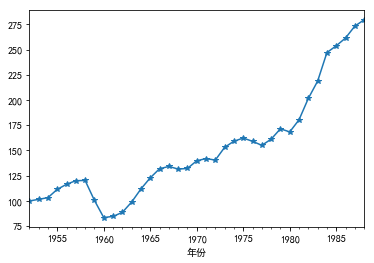

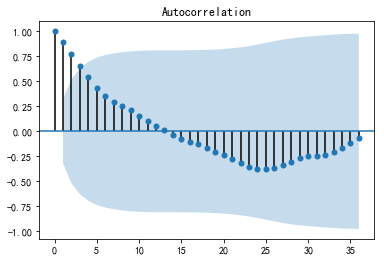

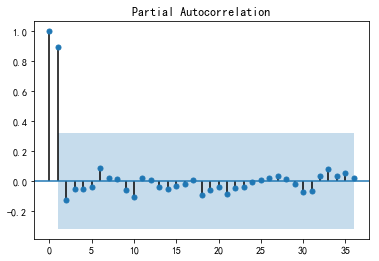

,类型,延迟阶数,检验结果,Test Statistic,p-value,Lags Used,Number of observations Used,Critical value(1%),Critical value(5%),Critical value(10%)
0,类型1,0,非平稳,4.02206,1,0,36,-2.63064,-1.95039,-1.61099
1,类型1,1,非平稳,1.69041,0.978356,1,35,-2.63258,-1.95069,-1.61086
2,类型1,2,非平稳,1.86751,0.986031,2,34,-2.63464,-1.95102,-1.61071
3,类型2,0,非平稳,2.17229,0.998859,0,36,-3.62665,-2.94595,-2.61167
4,类型2,1,非平稳,0.487806,0.984498,1,35,-3.63274,-2.94851,-2.61302
5,类型2,2,非平稳,0.778897,0.991288,2,34,-3.63922,-2.95123,-2.61445
6,类型3,0,非平稳,-0.398556,0.986922,0,36,-4.23506,-3.54039,-3.20238
7,类型3,1,非平稳,-1.58185,0.799458,1,35,-4.24377,-3.54436,-3.20465
8,类型3,2,非平稳,-1.30775,0.885999,2,34,-4.25304,-3.54859,-3.20706


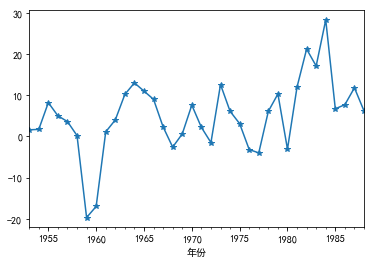

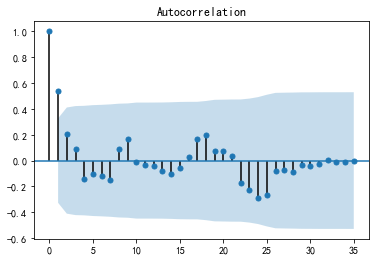

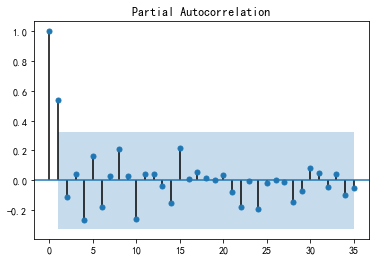

,类型,延迟阶数,检验结果,Test Statistic,p-value,Lags Used,Number of observations Used,Critical value(1%),Critical value(5%),Critical value(10%)
0,类型1,0,平稳,-2.65322,0.00773899,0,35,-2.63258,-1.95069,-1.61086
1,类型1,1,平稳,-2.42259,0.0148687,1,34,-2.63464,-1.95102,-1.61071
2,类型2,0,平稳,-3.15606,0.0226734,0,35,-3.63274,-2.94851,-2.61302
3,类型2,1,平稳,-3.00567,0.0343687,1,34,-3.63922,-2.95123,-2.61445
4,类型3,0,平稳,-3.51942,0.037358,0,35,-4.24377,-3.54436,-3.20465
5,类型3,1,平稳,-3.49025,0.0404458,1,34,-4.25304,-3.54859,-3.20706


,延迟期数,Q_LB统计量,P值,接受白噪音假设
0,6,15.330418,0.017837,False
1,12,18.330818,0.106009,True
2,18,24.664749,0.134433,True



para
 const         4.995611
ma.L1.D.农业    0.671032
dtype: float64


/Users/pengju/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/pengju/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/pengju/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/pengju/anaconda3/lib/python3.6/site-

,预测值,标准差,5%置信区间下限,5%置信区间上限
0,285.096657,7.308574,270.772115,299.421199
1,290.092268,14.232680,262.196727,317.987809
2,295.087879,18.754283,258.330160,331.845598
3,300.083490,22.380283,256.218941,343.948039
4,305.079101,25.495706,255.108436,355.049766
5,310.074712,28.269859,254.666806,365.482618
6,315.070323,30.795111,254.713014,375.427632
7,320.065934,33.128429,255.135406,384.996462
8,325.061545,35.307885,255.859362,394.263728
9,330.057156,37.360416,256.832086,403.282226


In [18]:
农业收入=pd.read_excel(os.path.join(案例数据,"附录1.18.xls"))
农业收入['年份']=pd.to_datetime(农业收入['年份'],format='%Y')
农业收入.set_index('年份',inplace=True)
农业收入=农业收入['农业']

农业收入.plot(marker='*')
plt.show()
sm.graphics.tsa.plot_acf(农业收入)
sm.graphics.tsa.plot_pacf(农业收入)
plt.show()
display(adf_check_table(农业收入,max_lag=2,threshod=0.05))

农业收入差分=农业收入.diff().dropna()
农业收入差分.plot(marker='*')
plt.show()
sm.graphics.tsa.plot_acf(农业收入差分)
sm.graphics.tsa.plot_pacf(农业收入差分)
plt.show()
display(adf_check_table(农业收入差分,max_lag=1,threshod=0.05))
display(my_Q_LB(农业收入差分,out_lags_list=[6,12,18]))


# 拟合ARIMA 
model=ARIMA(endog=农业收入,order=(0,1,1))
results=model.fit()
print('\npara\n',results.params)

my_Q_LB(results.resid,out_lags_list=[6,12,18])

# 预测
display(confidence_interval(results,steps=10))



## 例题4-9 简单季节差分（差分 N步差分）

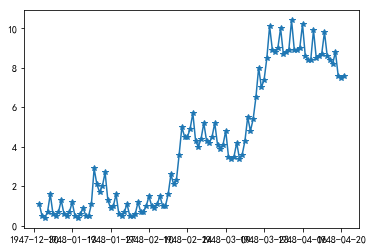

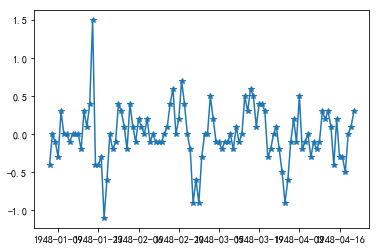

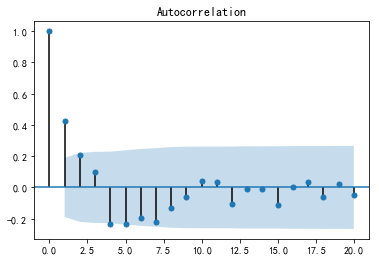

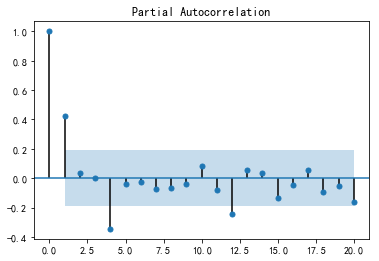

,延迟期数,Q_LB统计量,P值,接受白噪音假设
0,6,42.632142,1.379192e-07,False
1,12,52.594669,4.862721e-07,False
2,18,54.804465,1.374019e-05,False


ar.L1      0.660005
ma.L1     -0.291604
ma.S.L4   -0.590122
sigma2     0.090120
dtype: float64


,延迟期数,Q_LB统计量,P值,接受白噪音假设
0,6,7.557360,0.272358,True
1,12,18.382255,0.104567,True
2,18,26.203863,0.095187,True


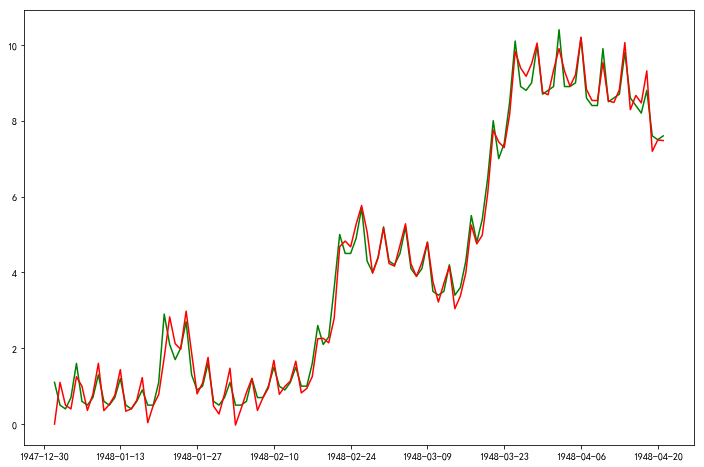

In [19]:
德国工人失业= pd.Series(pd.read_excel(os.path.join(案例数据,"附录1.20.xls"),header=None)[:14].values.flatten()).astype(float)
德国工人失业.index=[datetime.datetime(1948,1,1)+datetime.timedelta(days=i) for i in range( len(德国工人失业))]
plt.plot(德国工人失业,marker='*')
plt.show()

德国工人失业差分后4步差分 =德国工人失业.diff().diff(4).dropna()
plt.plot(德国工人失业差分后4步差分,marker='*')
plt.show()


sm.graphics.tsa.plot_acf(德国工人失业差分后4步差分,lags=20)
plt.show()

sm.graphics.tsa.plot_pacf(德国工人失业差分后4步差分,lags=20)
plt.show()

display(my_Q_LB(德国工人失业差分后4步差分,out_lags_list=[6,12,18],p_threshold=0.05))

model=SARIMAX(endog=德国工人失业,order=(1,1,1),seasonal_order=(0,1,1,4))
results=model.fit()
print(results.params)
display(my_Q_LB(results.resid,out_lags_list=[6,12,18]))
# results.forecast(steps=5,alpha=0.05)


plt.figure(figsize=(12,8))
plt.plot(德国工人失业,color='g')
plt.plot(results.fittedvalues,color='r')
plt.show()

    
    

 从源码可以看出没有办法使用稀疏系数
 
        if isinstance(order[0], (int, long, np.integer)):
            self.polynomial_ar = np.r_[1., np.ones(order[0])]
        else:
            self.polynomial_ar = np.r_[1., order[0]]
        if isinstance(order[2], (int, long, np.integer)):
            self.polynomial_ma = np.r_[1., np.ones(order[2])]
        else:
            self.polynomial_ma = np.r_[1., order[2]]
            

# 乘积季节模型 

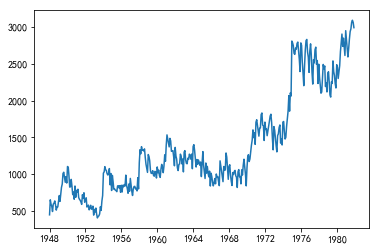

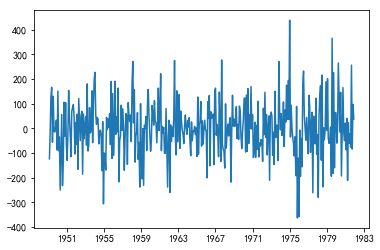

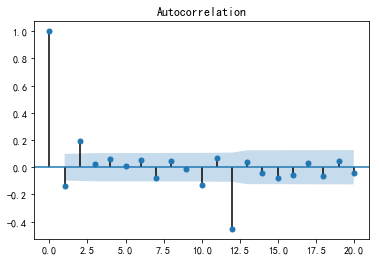

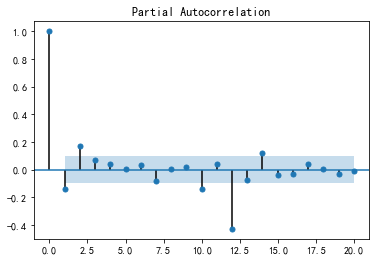

ar.L1         -0.727211
ma.L1          0.603801
ma.S.L12      -0.791913
sigma2      7444.640037
dtype: float64


,延迟期数,Q_LB统计量,P值,接受白噪音假设
0,6,5.168649,0.522372,True
1,12,9.747165,0.638131,True
2,18,16.348282,0.568255,True


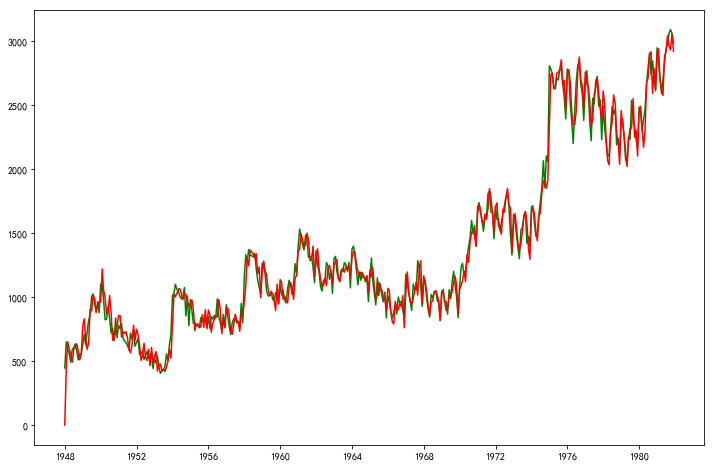

In [21]:
# 绘制时序图
美失业=pd.Series(pd.read_excel(os.path.join(案例数据,"附录1.21.xls"),header=None)[:46].values.flatten()).dropna().astype(float)
美失业.index=[datetime.datetime(1948,1,1)+relativedelta(months=i) for i in range( len(美失业))]
plt.plot(美失业)
plt.show()

# 差分平稳化
美失业一阶12步差分 =美失业.diff().diff(12).dropna()
plt.plot(美失业一阶12步差分)
plt.show()

# 模型定阶

sm.graphics.tsa.plot_acf(美失业一阶12步差分,lags=20)
plt.show()

sm.graphics.tsa.plot_pacf(美失业一阶12步差分,lags=20)
plt.show()

#  结果分析（自相关图 偏相关图  1阶和2阶自相关系数 短期相关性） 
model=SARIMAX(endog=美失业,order=(1,1,1),seasonal_order=(0,1,1,12))
results=model.fit()
print(results.params)
display(my_Q_LB(results.resid,out_lags_list=[6,12,18]))

plt.figure(figsize=(12,8))
plt.plot(美失业,color='g')
plt.plot(results.fittedvalues,color='r')
plt.show()

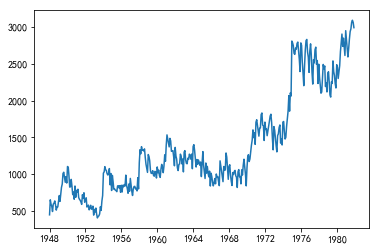

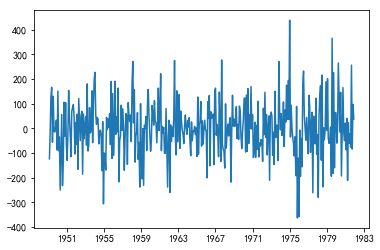

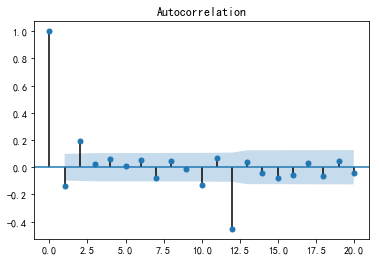

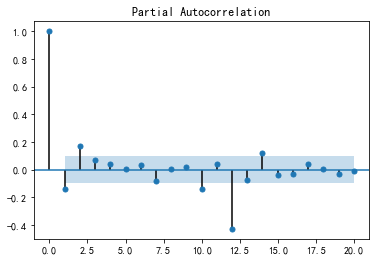

ar.L1         -0.993552
ma.L1          0.999871
ar.S.L12       0.006025
ma.S.L12      -0.798989
sigma2      7642.116605
dtype: float64


/Users/pengju/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,延迟期数,Q_LB统计量,P值,接受白噪音假设
0,6,15.021788,0.020088,False
1,12,20.088982,0.065421,True
2,18,25.097950,0.122242,True


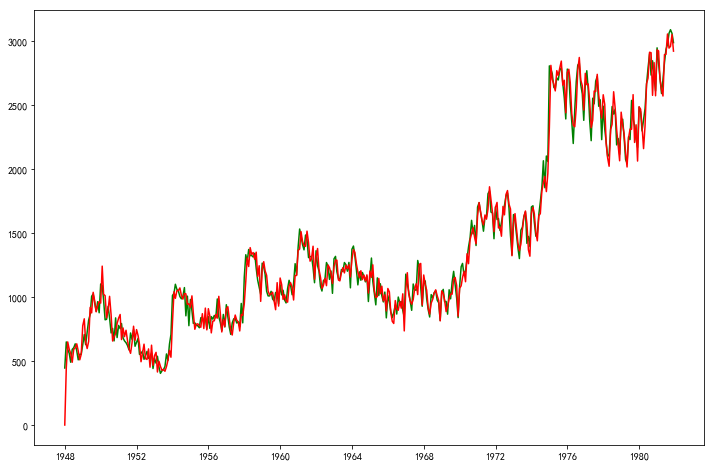

In [22]:
# 绘制时序图
美失业=pd.Series(pd.read_excel(os.path.join(案例数据,"附录1.21.xls"),header=None)[:46].values.flatten()).dropna().astype(float)
美失业.index=[datetime.datetime(1948,1,1)+relativedelta(months=i) for i in range( len(美失业))]
plt.plot(美失业)
plt.show()

# 差分平稳化
美失业一阶12步差分 =美失业.diff().diff(12).dropna()
plt.plot(美失业一阶12步差分)
plt.show()

# 模型定阶

sm.graphics.tsa.plot_acf(美失业一阶12步差分,lags=20)
plt.show()

sm.graphics.tsa.plot_pacf(美失业一阶12步差分,lags=20)
plt.show()

#  结果分析（自相关图 偏相关图  1阶和2阶自相关系数 短期相关性） 
model=SARIMAX(endog=美失业,order=(1,1,1),seasonal_order=(1,1,1,12))
results=model.fit()
print(results.params)
display(my_Q_LB(results.resid,out_lags_list=[6,12,18]))

plt.figure(figsize=(12,8))
plt.plot(美失业,color='g')
plt.plot(results.fittedvalues,color='r')
plt.show()

# 残差自回归模型

- 思想：
    - 因素分解方法 vs 差分方法： 前者直观 后者提取更彻底
    - 残差自回归= 因素分解后，如果残差有自相关性，就用自回归模型进行拟合  
        - 可以理解 先进行线性回归 再进行残差拟合（没有进行周期性拟合的例子，所以暂时先不深入探讨 ）       

# 例题 4-6续 

In [ ]:
农业收入=pd.read_excel(os.path.join(案例数据,"附录1.18.xls"))
农业收入['年份']=pd.to_datetime(农业收入['年份'],format='%Y')
农业收入.set_index('年份',inplace=True)
农业收入=农业收入['农业']



农业收入X = np.array(list(range(1,1+len(农业收入))))
农业收入X = sm.add_constant(农业收入X)
线性model=OLS(endog=农业收入,exog=农业收入X)
线性resuls=线性model.fit()
print("自变量用时间进行拟合的参数\n",线性resuls.params)



回归model=ARMA(endog=农业收入,order=(1,0))
回归results=回归model.fit(trend='nc')
print(回归results.params)
display(my_Q_LB(回归results.resid,out_lags_list=[6,12,18]))



plt.figure(figsize=(12,8))
plt.plot(农业收入,color='g',ls='dashed',marker='*',label='真实值')
plt.plot(线性resuls.fittedvalues,'r',label='线性拟合值')
plt.plot(回归results.fittedvalues,color='b',label='回归拟合值')
plt.legend(loc='best')
plt.show()


In [ ]:
农业收入线性残差=农业收入-线性resuls.fittedvalues
sm.graphics.tsa.plot_acf(农业收入线性残差,lags=20)
plt.show()

sm.graphics.tsa.plot_pacf(农业收入线性残差,lags=20)
plt.show()






- pacf 二阶截尾，用AR(2)进行拟合


In [ ]:
print("用ARIMA(0,1,1)进行拟合")
ARIMA_model=ARIMA(endog=农业收入,order=(0,1,1))
ARIMA_results=ARIMA_model.fit(trend='c')
print(ARIMA_results.params)
print(ARIMA_results.bic)




- pyflux statsmodel  arch没有找到 残差自回归模型的实现，所以不予深入探索

# 异方差性质
    - 方差齐性

In [ ]:
美失业=pd.Series(pd.read_excel(os.path.join(案例数据,"附录1.22.xls"),header=None)[:46].values.flatten()).dropna().astype(float)
美失业.index=[datetime.datetime(1948,1,1)+relativedelta(months=i) for i in range( len(美失业))]
plt.plot(美失业)
plt.show()


In [ ]:
美国库券=pd.Series(pd.read_excel(os.path.join(案例数据,"附录1.22.xls"),header=None).values.flatten()).dropna().astype(float)
美国库券.index=[datetime.datetime(1963,4,1)+relativedelta(months=i) for i in range( len(美国库券))]
plt.plot(美国库券)
plt.show()

美国库券差分=美国库券.diff().dropna()

plt.plot(美国库券差分)
plt.show()
plt.plot(美国库券差分**2)
plt.show()


- 发现方差不平稳

### 方差进行齐次变换
    - 具体方法：进行对数变换
    - 重要假设：金融序列的标准差与均值之间存在正相关关系，异方差描述为  
$h(\mu_t)=u^2_t$
 可以进行对数变换；转让为方差齐性，就可以用同方差的方法进行拟合

In [ ]:
对数美国库券=np.log(美国库券)
对数美国库券差分=对数美国库券.diff().dropna()
plt.plot(美国库券)
plt.show()
plt.plot(对数美国库券)
plt.show()
plt.plot(对数美国库券差分)
plt.show()
display(my_Q_LB(对数美国库券差分,out_lags_list=[6,12,18]))

sm.graphics.tsa.plot_acf(对数美国库券差分,lags=20)
plt.show()

sm.graphics.tsa.plot_pacf(对数美国库券差分,lags=20)
plt.show()



sm.graphics.tsa.plot_acf(对数美国库券,lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(对数美国库券,lags=20)
plt.show()


#  结果分析（自相关图 偏相关图  1阶和2阶自相关系数 短期相关性） 
model=ARIMA(endog=对数美国库券,order=(1,0,0))
results=model.fit()
print(results.params)
display(my_Q_LB(results.resid,out_lags_list=[6,12,18]))

plt.figure(figsize=(12,8))
plt.plot(美国库券,color='g')
plt.plot(np.exp(results.fittedvalues),color='r')
plt.show()


In [ ]:
model=ARIMA(endog=对数美国库券,order=(1,0,0))
results=model.fit(trend='nc')
print(results.params)
display(my_Q_LB(results.resid,out_lags_list=[6,12,18]))
plt.figure(figsize=(12,8))
fit_value=results.fittedvalues
fit_value=fit_value[fit_value<0]
plt.plot(对数美国库券,color='g')
plt.plot(fit_value,color='r')

plt.show()
plt.figure(figsize=(12,8))
plt.plot(np.exp(对数美国库券),color='g')
plt.plot(np.exp(fit_value),color='r',marker='*',ls='dashed')
plt.show()


# 条件异方差模型
    - ARCH 自回归条件异方差模型
    - 基本假设： 零均值、纯随机残差具有异方差性，异方差等于残差平方的均值，残差平方序列的自相关系数-->如果不为零，则存在异方差波动特征
    - 作用
        - 是什么？  提取水平相关信息，再提取残差中的波动相关信息； 
        - 为什么？  用历史波动信息作为条件，自回归方式刻画波动变化；及时反映序列近期波动的特征；
        - 解决什么问题？ 实际是异方差，但是用齐方差进行预测，当方差波动较大时，实际残差的真实方法比预测方差大很多，这样是不对的
        - 怎么做？ ARCH检验（异方差性和残差自相关性） PQ LM方法

In [ ]:
标普=pd.read_excel(os.path.join(案例数据,"附录1.23.xls"))
标普.columns=['Month','return']
标普.set_index("Month",inplace=True)
标普=标普['return']

plt.plot(标普)
plt.show()

plt.plot(标普.loc['1926-01-01':'1936-01-01'])
plt.show()

- 某个阶段的方差明显与期望方差不同

In [ ]:
# 验证标普是否是异方差
my_LM_test(标普)


### GARCH  
- 相对于ARCH：  ARCH 异方差函数**短期自相关**，但是 GARCH可以处理**长期自相关性**
- AR-GARCH: 先拟合自回归模型，再考察自回归残差序列的方差齐性，判断是否需要使用GARCH
- GARCH模型局限性在于（1）对参数约束严格，限制了使用范围（2）对正负扰动对称，与实际不符
- EGARCH/IGARCH/等方法    


如何对模型进行预测？ 结果如何回溯？ 如何对未来进行预测？

 不同的参数应该如何选择？ 怎样效果更好？
 

## 例题 4-13  GARCH进行预测的流程探索

In [ ]:
外汇兑换=pd.read_excel(os.path.join(案例数据,"附录1.24.xls"))
外汇兑换.columns=['Date','rate']
外汇兑换.set_index("Date",inplace=True)
外汇兑换=外汇兑换['rate']

print("时序图")
plt.plot(外汇兑换)
plt.show()

print("差分时序图")
外汇兑换差分=外汇兑换.diff().dropna()
plt.plot(外汇兑换差分)
plt.show()


- 序列有趋势；差分序列有集群小赢； 应该同时提取水平相关信息和波动相关信息

#### 水平信息拟合(类似于  残差自回归模型的构建过程) 
- LM 验证：已完成
（核心问题： arch 的参数调整+ 验证Q和LM验证,实际中不需要进行，因为结果的summary中自动就包含了这个部分的内容）
（最终结果要出一个思维导图）
- 回归模型拟合- 自相关函数(通过观察一阶差分后的情况，可以认为属于AR(1))
- 残差自相关拟合
    - 进行DW校验残差的自相关性       

In [ ]:
#  编写LM 和Q 测试

In [ ]:
print("水平信息拟合")

model=ARIMA(endog=外汇兑换,order=(1,0,0))
results=model.fit(trend='nc')
print(results.params)
display(my_Q_LB(results.resid,out_lags_list=[6,12,18]))


外汇兑换残差=results.resid[1:]
plt.plot(外汇兑换残差)
plt.show()


残差model=ARIMA(endog=外汇兑换残差,order=(1,0,0))
残差results=残差model.fit(trend='nc')
print(残差results.params)
外汇兑换残差的残差=残差results.resid[1:]
plt.plot(外汇兑换残差的残差)
plt.show()




### 进行LMtest

In [ ]:
# 检查序列的异方差性
def my_LM_test(ts,out_lags_list=range(1,10),p_threshold=0.05):
    from statsmodels.stats.diagnostic import het_arch
    list_df=[]
    for l in out_lags_list:
        rst=het_arch(ts,maxlag=l)
        tmp_l=[l]+list(rst[:2])+[rst[1]<p_threshold]
        list_df.append(tmp_l)
        print(tmp_l)
    df=pd.DataFrame(list_df,columns=['延迟期数','LM统计量','P值','接受异方差假设'])
    return df    
    
my_LM_test(外汇兑换残差的残差)

In [ ]:
from arch import  arch_model

model=arch_model(外汇兑换残差的残差,mean='Constant',vol='GARCH',p=1,q=1)
result=model.fit()
print(result.summary)

# 与书上P151参数接近
model=arch_model(外汇兑换残差的残差,mean='Zero',vol='GARCH',p=1,q=1)
result=model.fit()
print(result.summary)


arch中 将模型抽象为 mean 水平部分 + vol残差部分
- mean部分最常用 Zero Constant AR 
- vol 部分使用的是 ARCH GARCH EGARCH确定函数的形式，配合使用不同的 p q o power 等参数进行具体的定阶
- 如何对结果进行回测，查看拟合的准确程度；如何对未来结果进行预测，获取预测值

In [ ]:
# 结果与预期不一致，可能是什么问题导致的呢？通过尝试对比发现：差异在于 mean是否允许设置为 Co
# Const 还是Zero
#  与下面block区别在于一个是合并在一起，一个是分开；结果是一致的
from arch import  arch_model

model=arch_model(外汇兑换残差,mean='ARX',vol='GARCH',p=1,q=1,lags=[1])
result=model.fit()
print(result.summary)



In [ ]:
from arch import  arch_model

model=arch_model(外汇兑换残差,mean='ARX',vol='GARCH',p=1,q=1,lags=[1])
split_date = datetime.datetime(1995,1,1)
res = model.fit(last_obs=split_date)

# 循环计算未来的值
forecasts = res.forecast(horizon=2, start=split_date)
forecasts.variance[split_date:].plot()
plt.show()
forecasts = res.forecast(horizon=5, start=split_date, method='simulation')
forecasts.variance[split_date:].plot()
plt.show()


In [ ]:
# 结果与预期不一致，可能是什么问题导致的呢？
from arch.univariate import  ARCH,ARX,GARCH
ar=ARX(外汇兑换残差,constant=False,lags=[1])
print(ar.fit().summary())
ar.volatility=GARCH(p=1,q=1)
res = ar.fit(update_freq=0, disp='off')
print(res.summary())


In [ ]:
result.hedgehog_plot(horizon=10)

In [ ]:
help(arch_model)